<a href="https://colab.research.google.com/github/Alfaalputra/analisis-sentimen-speech-to-text-bahasa-Indonesia/blob/main/Sentimen_Analis_speech_to_text_menggunakan_Transformers_and_Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install Transformer

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 


import semua library yang dibutuhkan

In [ ]:
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers.optimization import  AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer


%matplotlib inline
RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

read dataset

In [ ]:
dataset = pd.read_csv('reviews.csv')
dataset.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


plot nilai review score dari dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


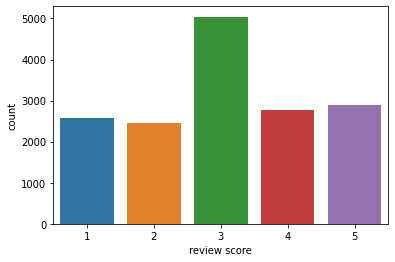

In [ ]:
sns.countplot(dataset.score)
plt.xlabel('review score');

fungsi untuk mengubah nilai review score dataset menjadi 0,1,2

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [ ]:
dataset['sentiment'] = dataset.score.apply(to_sentiment)

In [ ]:
dataset.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


kelas klasifikasi text ada 3 yaitu negatif, netral, dan positif

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


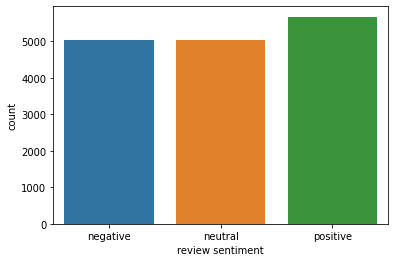

In [ ]:
ax = sns.countplot(dataset.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

download pre-trained model bert

In [ ]:
pre_trained_model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model)

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

hitung panjang token pada dataset dan menentukan max length

In [ ]:
token_lens = []
for txt in dataset.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


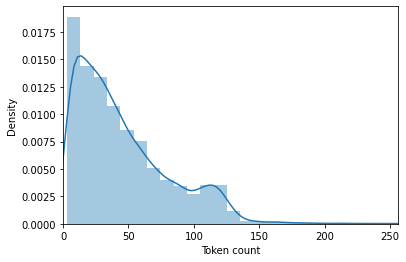

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 160

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

split dataset menjadi tran dan test

In [ ]:
df_train, df_test = train_test_split(
  dataset,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
5902,דוד קמחי,https://lh3.googleusercontent.com/a-/AOh14GjiG...,Great app,5,0,4.15.0,2020-04-06 19:33:55,NaN,NaN,newest,cc.forestapp,2
14579,Amber Randall,https://lh3.googleusercontent.com/-yoLOfd7nfPY...,ANNOYED paid for this years ago PAID full vers...,1,173,4.5.7,2019-04-27 23:34:21,NaN,NaN,most_relevant,com.appxy.planner,0
4723,Thea Draves,https://lh3.googleusercontent.com/-jetUkyAlM_k...,Helpful,5,0,NaN,2020-03-24 22:17:04,NaN,NaN,newest,com.habitrpg.android.habitica,2
6209,RonJonae Felder,https://lh3.googleusercontent.com/-G2tnfw6TKn8...,While i can understand limiting somethings for...,2,1,NaN,2019-11-05 08:42:24,NaN,NaN,most_relevant,com.oristats.habitbull,0
7078,Lynne LaRochelle Richard,https://lh3.googleusercontent.com/a-/AOh14Gh4B...,Elegant design. This app is easy to use and on...,5,8,1.5.11,2019-03-19 12:27:21,NaN,NaN,most_relevant,com.oristats.habitbull,2


In [ ]:
df_test.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
11789,amir Abedini,https://lh3.googleusercontent.com/-sJzcOm4RO6g...,Best! But bringing menu bar from side to below...,5,0,2.7.1,2020-04-02 08:35:38,Thanks for your feedback 👍 We're open to all p...,2020-04-02 08:51:30,most_relevant,com.gmail.jmartindev.timetune,2
6509,Rasi,https://lh3.googleusercontent.com/a-/AOh14GgsO...,I would have loved this app except for the fac...,3,0,1.5.11,2018-11-21 04:08:10,NaN,NaN,most_relevant,com.oristats.habitbull,1
14881,Aiman Ariffin,https://lh3.googleusercontent.com/a-/AOh14GgvV...,I just installed this app and it's always on l...,2,0,4.3.7,2018-03-11 03:00:51,NaN,NaN,newest,com.appxy.planner,0
5386,Sam Munoz,https://lh3.googleusercontent.com/a-/AOh14Gjai...,"Hey, I downloaded the app and paid for the pre...",3,0,4.10.7,2019-10-31 17:41:02,"Hi,\nYou will gain 7000 coins from the achieve...",2019-11-06 10:30:01,most_relevant,cc.forestapp,1
6485,Nicholas Rivett,https://lh3.googleusercontent.com/a-/AOh14Gil5...,Used to work great. Unfortunetly notifications...,3,0,1.5.11,2018-11-05 20:38:45,NaN,NaN,most_relevant,com.oristats.habitbull,1


split data test menjadi dataset test dan validation

In [ ]:
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_val.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
403,Hansraj Choudhary,https://lh3.googleusercontent.com/a-/AOh14GhHe...,Happy with the App...but personally I had two ...,3,11,4.17.0.2,2020-03-17 21:37:55,You may find completed tasks under Settings - ...,2020-03-18 04:23:12,most_relevant,com.anydo,1
4744,Carrie Burton,https://lh3.googleusercontent.com/a-/AOh14Gj-B...,This is such a fun way for chores to be reward...,5,0,2.4.4,2020-03-09 22:41:05,"Thanks so much for your review, we're happy to...",2020-04-03 04:15:19,newest,com.habitrpg.android.habitica,2
13703,Stephan Lehmann,https://lh3.googleusercontent.com/-xYGMQwJuyj0...,Gtasks Sync doens´t work. Calendar Sync is ok,2,0,2.37.0,2019-12-18 23:46:36,"Hi, we have already identified the problem and...",2019-12-19 11:41:39,newest,com.appgenix.bizcal,0
1925,Josh Kramer,https://lh3.googleusercontent.com/a-/AOh14GgRZ...,"Seems pretty good, but totally crippled the fr...",3,0,NaN,2019-06-15 13:04:59,NaN,NaN,newest,com.todoist,1
5527,anya M,https://lh3.googleusercontent.com/a-/AOh14Gjh-...,Let me try it first,3,0,4.13.1,2020-02-17 14:22:51,"Hi,\nThank you for the rating! Don't hesitate ...",2020-02-19 16:32:14,newest,cc.forestapp,1


In [ ]:
df_test.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
210,Petar Janotka,https://lh3.googleusercontent.com/-iIe5e6_PayM...,Missing grocery list widget and quantity for g...,2,0,4.17.0.2,2020-03-20 22:47:41,NaN,NaN,most_relevant,com.anydo,0
1782,Saumya Kaushik,https://lh3.googleusercontent.com/a-/AOh14GjVD...,Nice app,3,0,15.2.0,2020-03-08 03:39:41,NaN,NaN,most_relevant,com.todoist,1
8374,L Jones,https://lh3.googleusercontent.com/-_cfmtZFBHQE...,Very good. Considering going premium.,5,0,1.2.3,2020-02-20 22:55:43,NaN,NaN,newest,com.habitnow,2
8023,Shiro Gato,https://lh3.googleusercontent.com/a-/AOh14Gi__...,This app works nice if you want to track daily...,3,9,1.2.1,2019-10-26 08:41:59,NaN,NaN,newest,com.habitnow,1
10134,Dave Jewett,https://lh3.googleusercontent.com/-hoH9hyJrPBs...,It's such a bummer it doesn't work on the Sams...,3,0,5.3.2,2017-12-02 21:36:26,NaN,NaN,most_relevant,prox.lab.calclock,1


membuat dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_data_loader

contoh batch dari dataloader

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


load model Bert

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
bert_model = BertModel.from_pretrained(pre_trained_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

fungssi untuk klasifikasi text menggunakan model Bert

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pre_trained_model)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model summary

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


penerapan softmax pada pre-trained model

In [ ]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1681, 0.5324, 0.2994],
        [0.2268, 0.4044, 0.3687],
        [0.2915, 0.3683, 0.3402],
        [0.2893, 0.3825, 0.3282],
        [0.2241, 0.4900, 0.2858],
        [0.3127, 0.3671, 0.3202],
        [0.1611, 0.5396, 0.2992],
        [0.1318, 0.5248, 0.3434],
        [0.2865, 0.3675, 0.3460],
        [0.2382, 0.4249, 0.3369],
        [0.2197, 0.4444, 0.3359],
        [0.1436, 0.6779, 0.1785],
        [0.1548, 0.3250, 0.5202],
        [0.1675, 0.5051, 0.3274],
        [0.2070, 0.5556, 0.2375],
        [0.1517, 0.4930, 0.3552]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

menentukan hyperparameter sebelum memulai proses training

In [ ]:
EPOCHS = 15
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

proses training menuggnakan 15 epoch

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/15
----------
Train loss 0.7336864125647878 accuracy 0.6662197445487263
Val   loss 0.5991910469532012 accuracy 0.7509529860228717

Epoch 2/15
----------
Train loss 0.41740592530430304 accuracy 0.8425658034013126
Val   loss 0.48451047971844674 accuracy 0.8195679796696316

Epoch 3/15
----------
Train loss 0.2448350467837918 accuracy 0.922588384729377
Val   loss 0.47900985181797295 accuracy 0.8627700127064803

Epoch 4/15
----------
Train loss 0.170221983100357 accuracy 0.9508150448098229
Val   loss 0.550362650109455 accuracy 0.8716645489199493

Epoch 5/15
----------
Train loss 0.13683923755258134 accuracy 0.9626702420436102
Val   loss 0.6296271734172478 accuracy 0.8691232528589581

Epoch 6/15
----------
Train loss 0.10113396177061257 accuracy 0.9716322066191518
Val   loss 0.6106991030613426 accuracy 0.8792884371029225

Epoch 7/15
----------
Train loss 0.08004113291189535 accuracy 0.9768541387340344
Val   loss 0.7043232261412777 accuracy 0.8831003811944091

Epoch 8/15
----------
Tr

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.6662, device='cuda:0', dtype=torch.float64),
              tensor(0.8426, device='cuda:0', dtype=torch.float64),
              tensor(0.9226, device='cuda:0', dtype=torch.float64),
              tensor(0.9508, device='cuda:0', dtype=torch.float64),
              tensor(0.9627, device='cuda:0', dtype=torch.float64),
              tensor(0.9716, device='cuda:0', dtype=torch.float64),
              tensor(0.9769, device='cuda:0', dtype=torch.float64),
              tensor(0.9812, device='cuda:0', dtype=torch.float64),
              tensor(0.9829, device='cuda:0', dtype=torch.float64),
              tensor(0.9848, device='cuda:0', dtype=torch.float64),
              tensor(0.9870, device='cuda:0', dtype=torch.float64),
              tensor(0.9877, device='cuda:0', dtype=torch.float64),
              tensor(0.9877, device='cuda:0', dtype=torch.float64),
              tensor(0.9891, device='cuda:0', dtype=torch.float64),
              ten

In [ ]:
history['train_acc']

[tensor(0.6662, device='cuda:0', dtype=torch.float64),
 tensor(0.8426, device='cuda:0', dtype=torch.float64),
 tensor(0.9226, device='cuda:0', dtype=torch.float64),
 tensor(0.9508, device='cuda:0', dtype=torch.float64),
 tensor(0.9627, device='cuda:0', dtype=torch.float64),
 tensor(0.9716, device='cuda:0', dtype=torch.float64),
 tensor(0.9769, device='cuda:0', dtype=torch.float64),
 tensor(0.9812, device='cuda:0', dtype=torch.float64),
 tensor(0.9829, device='cuda:0', dtype=torch.float64),
 tensor(0.9848, device='cuda:0', dtype=torch.float64),
 tensor(0.9870, device='cuda:0', dtype=torch.float64),
 tensor(0.9877, device='cuda:0', dtype=torch.float64),
 tensor(0.9877, device='cuda:0', dtype=torch.float64),
 tensor(0.9891, device='cuda:0', dtype=torch.float64),
 tensor(0.9895, device='cuda:0', dtype=torch.float64)]

In [ ]:
history['train_loss']

[0.7336864125647878,
 0.41740592530430304,
 0.2448350467837918,
 0.170221983100357,
 0.13683923755258134,
 0.10113396177061257,
 0.08004113291189535,
 0.06523113818390482,
 0.05423473821846247,
 0.046082640657557225,
 0.04095908878958616,
 0.03521205278102611,
 0.030783378658736562,
 0.028549846599566713,
 0.02691964019133478]

In [ ]:
history['val_acc']

[tensor(0.7510, device='cuda:0', dtype=torch.float64),
 tensor(0.8196, device='cuda:0', dtype=torch.float64),
 tensor(0.8628, device='cuda:0', dtype=torch.float64),
 tensor(0.8717, device='cuda:0', dtype=torch.float64),
 tensor(0.8691, device='cuda:0', dtype=torch.float64),
 tensor(0.8793, device='cuda:0', dtype=torch.float64),
 tensor(0.8831, device='cuda:0', dtype=torch.float64),
 tensor(0.8831, device='cuda:0', dtype=torch.float64),
 tensor(0.8831, device='cuda:0', dtype=torch.float64),
 tensor(0.8780, device='cuda:0', dtype=torch.float64),
 tensor(0.8818, device='cuda:0', dtype=torch.float64),
 tensor(0.8856, device='cuda:0', dtype=torch.float64),
 tensor(0.8933, device='cuda:0', dtype=torch.float64),
 tensor(0.8920, device='cuda:0', dtype=torch.float64),
 tensor(0.8920, device='cuda:0', dtype=torch.float64)]

In [ ]:
history['val_loss']

[0.5991910469532012,
 0.48451047971844674,
 0.47900985181797295,
 0.550362650109455,
 0.6296271734172478,
 0.6106991030613426,
 0.7043232261412777,
 0.687114670684532,
 0.7625390452268767,
 0.8762677496919059,
 0.823175537077841,
 0.810638605810891,
 0.8252534732507047,
 0.8207263056775992,
 0.8447343681360507]

plot hasil train loss dan validation loss

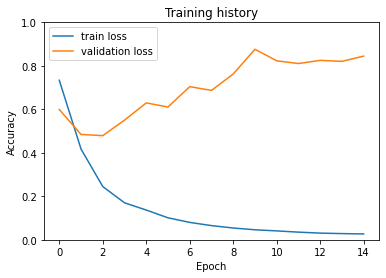

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

model yang telah di train, di ujicobakan pada data test

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8908629441624365

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

plot 

plot hasil model yang di ujicobakan ke dataset test menggunakan confusion matrix

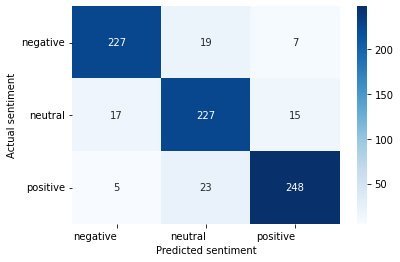

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('Actual sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90       253
     neutral       0.84      0.88      0.86       259
    positive       0.92      0.90      0.91       276

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



speech to text

In [ ]:
base = 'cahya/wav2vec2-large-xlsr-indonesian-mix'
tokenizer_speech = Wav2Vec2Tokenizer.from_pretrained(base)
model_speech = Wav2Vec2ForCTC.from_pretrained(base)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:757: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Proce

In [ ]:
model_speech

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

input audio

In [ ]:
import IPython.display as display
display.Audio("/content/test7_david.wav", autoplay=False)

In [ ]:
audio, rate = librosa.load("/content/test7_david.wav", sr = 16000)

In [ ]:
input_values = tokenizer_speech(audio, return_tensors = "pt").input_values
logits = model_speech(input_values).logits
prediction = torch.argmax(logits, dim = -1)
transcription = tokenizer_speech.batch_decode(prediction)[0]

hasil text dari speech

In [ ]:
transcription

'hapi ini cocok buat orang yang blajatnya juga sama ya meplet fleksi pa yan hapi yang kulitas tinggi api ingga rela buat keluarindua sampilima bua s iutahubi harga sama kalitasnya boasai ini udantas'

sentimen hasil speech to text

In [ ]:
review_text = transcription
encoded_review = tokenizer.encode_plus(review_text,
                                       max_length=MAX_LEN,
                                       add_special_tokens=True,
                                       return_token_type_ids=False,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: hapi ini cocok buat orang yang blajatnya juga sama ya meplet fleksi pa yan hapi yang kulitas tinggi api ingga rela buat keluarindua sampilima bua s iutahubi harga sama kalitasnya boasai ini udantas
Sentiment  : neutral
